# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [2]:
bike_rentals_train = pd.read_csv('../hwassets/data/Bikeshare_train.csv',
                                 usecols=range(1, 12))
bike_rentals_test = pd.read_csv('../hwassets/data/Bikeshare_test.csv',
                                usecols=range(1, 12))
int_cols = ['season', 'month', 'holiday', 'day_of_week', 'workingday', 'weather']
bike_rentals_train[int_cols] = bike_rentals_train[int_cols].astype('int64')
bike_rentals_test[int_cols] = bike_rentals_test[int_cols].astype('int64')

In [3]:
bike_rentals = pd.concat((bike_rentals_train, bike_rentals_test),
                         ignore_index=True)
bike_rentals.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,2,5,0,2,1,2,24.0,26.0,76.5833,0.118167,6073.0
1,4,12,0,2,1,1,15.0,19.0,73.3750,0.174129,6606.0
2,2,6,0,4,1,1,26.0,28.0,56.9583,0.253733,7363.0
3,4,12,0,0,0,1,0.0,4.0,58.6250,0.169779,2431.0
4,3,9,0,3,1,3,23.0,23.0,91.7083,0.097021,1996.0


In [4]:
def plot_variable(data, groupby, x_labels, title, kind, axes):
    axes.set_ylabel('Number of bike rentals')
    axes.set_title(title)
    axes.set_ylim((0, 4e6))
    data.groupby(by=groupby)['count'].sum().plot(kind=kind, ax=axes)
    if kind == 'bar':
        axes.set_xticklabels(x_labels);
        axes.set_xlabel('')
    elif kind == 'line':
        axes.set_xlabel(x_labels[0])

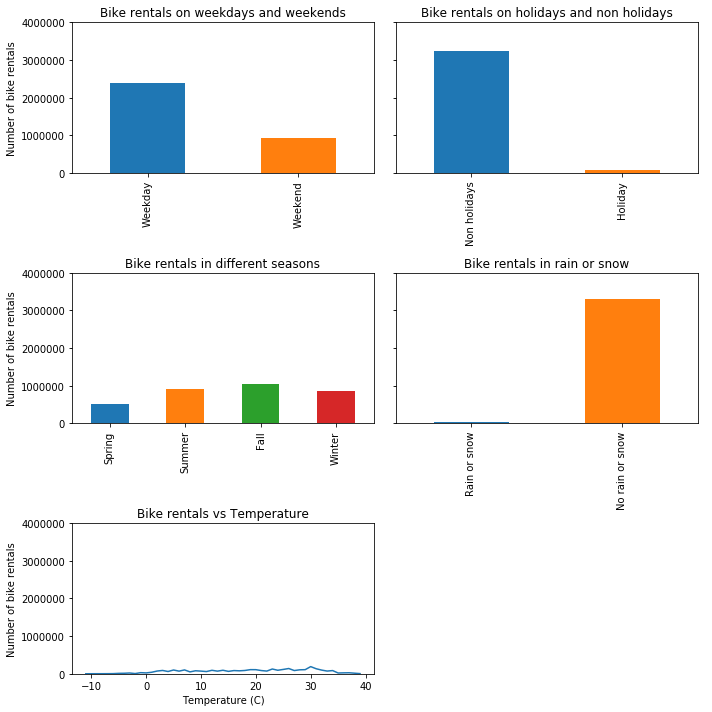

In [5]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(
    nrows=3, ncols=2, sharey=True, figsize=(10, 10))
plot_variable(bike_rentals, bike_rentals.day_of_week.isin([0, 6]),
              ['Weekday', 'Weekend'],
              'Bike rentals on weekdays and weekends',
              'bar', ax1)
plot_variable(bike_rentals, bike_rentals.holiday,
              ['Non holidays', 'Holiday'],
              'Bike rentals on holidays and non holidays',
              'bar', ax2)
plot_variable(bike_rentals, bike_rentals.season,
              ['Spring', 'Summer', 'Fall', 'Winter'],
              'Bike rentals in different seasons',
              'bar', ax3)
plot_variable(bike_rentals, bike_rentals.weather.isin([1, 2]),
              ['Rain or snow', 'No rain or snow'],
              'Bike rentals in rain or snow',
              'bar', ax4)
plot_variable(bike_rentals, bike_rentals.temp,
              ['Temperature (C)'],
              'Bike rentals vs Temperature',
              'line', ax5)
ax6.axis('off')
plt.tight_layout()

We notice the following about the above plots:

1. More bikes are rented on weekdays compared to the weekend.
2. Bikes are rented on non holidays for the vast majority of times.
3. More bikes are rented in the Summer, Fall and Winter months.
4. Unsurprisingly, bike rentals are almost exclusively rented when there is no rain or snow.
5. The number of bike rentals is particularly low in extreme weather conditions (0 C and below and over 35 C). It increases in between peaking in the most pleasant temperature range of 20 C to 30 C).

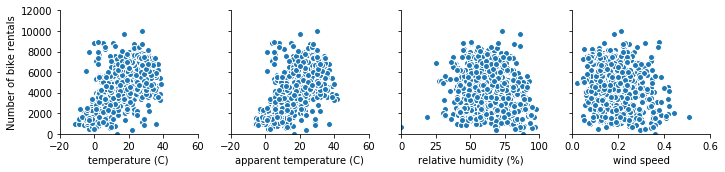

In [6]:
num_cols = ['temp', 'atemp', 'humidity', 'windspeed']
grid = sns.pairplot(bike_rentals, x_vars=num_cols, y_vars=['count'])
grid.fig.axes[0].set_ylabel('Number of bike rentals');
grid.fig.axes[0].set_xlabel('temperature (C)')
grid.fig.axes[1].set_xlabel('apparent temperature (C)')
grid.fig.axes[2].set_xlabel('relative humidity (%)')
grid.fig.axes[3].set_xlabel('wind speed')
grid.fig.axes[0].set_xlim((-20, 60))
grid.fig.axes[1].set_xlim(grid.fig.axes[0].get_xlim())
grid.fig.axes[2].set_xlim((0, 100))
grid.fig.axes[3].set_xlim((0., 0.6))
grid.fig.axes[0].set_ylim((0, 1.2e4));

We can clearly see that all the numeric attributes have a clear non-linear dependence with number of the bike rentals.

We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

In [7]:
def preprocess(train_data, test_data=None):
    other_col_names = ['holiday', 'workingday', 'count']
    if test_data:
        cat_cols = one_hot_encode_categoricals(test_data)
        num_cols_std = standardize_continous_predictors(train_data, test_data)
        other_cols = test_data[other_col_names]
    else:
        cat_cols = one_hot_encode_categoricals(train_data)
        num_cols_std = standardize_continous_predictors(train_data)
        other_cols = train_data[other_col_names]

    return pd.concat((cat_cols, num_cols_std, other_cols), axis=1)


def one_hot_encode_categoricals(data):
    cat_cols = ['season', 'month', 'day_of_week', 'weather']
    return pd.get_dummies(data[cat_cols], columns=cat_cols, drop_first=True)


def standardize_continous_predictors(train_data, test_data=None):
    num_cols = ['temp', 'atemp', 'humidity', 'windspeed']
    train_mean = train_data[num_cols].mean()
    train_std = train_data[num_cols].std()
    if test_data:
        data_standardized = test_data[num_cols].apply(
            lambda x: (x - train_mean[x.name]) / train_std[x.name])
    else:
        data_standardized = train_data[num_cols].apply(
            lambda x: (x - train_mean[x.name]) / train_std[x.name])
    return data_standardized

In [8]:
bike_rentals_train_pp = preprocess(bike_rentals_train)
bike_rentals_test_pp = preprocess(bike_rentals_test)
bike_rentals_train_pp.describe()

,season_2,season_3,season_4,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,day_of_week_6,weather_2,weather_3,temp,atemp,humidity,windspeed,holiday,workingday,count
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,...,331.000000,331.000000,331.000000,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,331.000000,331.000000,331.000000
mean,0.259819,0.265861,0.256798,0.066465,0.075529,0.078550,0.102719,0.072508,0.093656,0.081571,...,0.135952,0.329305,0.030211,-6.439964e-17,-1.314826e-16,-7.888956e-16,1.540225e-15,0.033233,0.670695,4598.447130
std,0.439199,0.442459,0.437528,0.249471,0.264643,0.269442,0.304051,0.259719,0.291790,0.274124,...,0.343256,0.470672,0.171428,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.179515,0.470672,1935.319338
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-2.503291e+00,-2.572131e+00,-2.648736e+00,-2.152869e+00,0.000000,0.000000,431.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-8.504011e-01,-8.603176e-01,-7.452412e-01,-7.381149e-01,0.000000,0.000000,3370.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,8.772587e-02,1.466312e-01,-6.562743e-03,-1.579037e-01,0.000000,1.000000,4648.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,8.024892e-01,7.508005e-01,7.055719e-01,5.693478e-01,0.000000,1.000000,5981.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.874634e+00,1.959139e+00,2.362380e+00,2.949989e+00,1.000000,1.000000,8714.000000


In [9]:
bike_rentals_train_pp.to_csv('../hwassets/data/Bikeshare_pp_train.csv')
bike_rentals_test_pp.to_csv('../hwassets/data/Bikeshare_pp_test.csv')

Categorical variables cannot be used directly as predictors in regression models since they are not numerical variables. Regression treats all independent variables as numerical. Numerical variables are directly comparable as they are interval or ratio scale variables. Categorical variables do not have this property as assigning ordinal numbers to each categorical value has no meaning in this since. As a result, [dummy variables](https://www.moresteam.com/whitepapers/download/dummy-variables.pdf) or indicator variables (binary predictors) should be created in this situation to ‘trick’ the regression algorithm into correctly analyzing attribute variables.

If there are K categories for the variable, then we only need K-1 binary predictors. The k-th binary predictor is not needed since it's information is already encoded in the K-1 binary predictors. If the k-th binary predictor is 1 then the K-1 binary predictors will all have value 0 or if the k-th binary predictor is zero, then exactly one of the K-1 predictors will have value 1. In fact including the k-th binary predictor is a bad thing since it can lead to collinearity issues.

The mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test set. The reason we do not include the test data in the mean and SD calculations is that this is data snooping. It causes us to leak information about the response of future data into the model that we build. This can result in considerable optimism bias during model evaluation. The issue is explained very well in the following:

- https://sebastianraschka.com/faq/docs/scale-training-test.html
- https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [10]:
def make_features(data, predictors=None):
    X = data.drop('count', axis=1)
    if predictors is not None:
        X = X.loc[:, predictors]
    X = sm.add_constant(X)
    y = data['count']
    return X, y

In [11]:
# make features
X_train, y_train = make_features(bike_rentals_train_pp)
X_test, y_test = make_features(bike_rentals_test_pp)

# fit model
ols = OLS(y_train, X_train)
ols_results = ols.fit()

# test model
y_test_predict = ols_results.predict(X_test)
test_r_squared = r2_score(y_test, y_test_predict)
print('Test R^2 = ', test_r_squared)
print()
print('Predictor p-values:')
print(ols_results.pvalues.drop('const'))
print()
print('Regression coefficients:')
print(ols_results.params.drop('const'))

Test R^2 =  0.25783629187453316

Predictor p-values:
season_2         0.066362
season_3         0.069897
season_4         0.016124
month_2          0.822906
month_3          0.592882
month_4          0.621999
month_5          0.927861
month_6          0.291523
month_7          0.117803
month_8          0.329365
month_9          0.560205
month_10         0.456178
month_11         0.856274
month_12         0.814248
day_of_week_1    0.469764
day_of_week_2    0.338484
day_of_week_3    0.425745
day_of_week_4    0.766631
day_of_week_5    0.576936
day_of_week_6    0.084976
weather_2        0.937215
weather_3        0.003026
temp             0.052000
atemp            0.468024
humidity         0.000002
windspeed        0.001744
holiday          0.476577
workingday       0.063440
dtype: float64

Regression coefficients:
season_2          898.829039
season_3         1032.881575
season_4         1226.186543
month_2            88.940093
month_3           239.180898
month_4           333.349086
mont

The estimated coefficients that are statistically significant at a significance level of 5% (p-value<0.05) are:
- season_4
- weather_3
- humidity
- windspeed

Amongst these predictors, the following preddictors have a positive correlation with the number of bike rentals:
- season_4

The day of a week, the month and holidays all do not have a statistically significant relationship with bike rentals.

Yes there is a difference in the coefficients assigned to `temp` and `atemp`. `temp` increases the number of bike rentals approximately 3 times more than `atemp`.

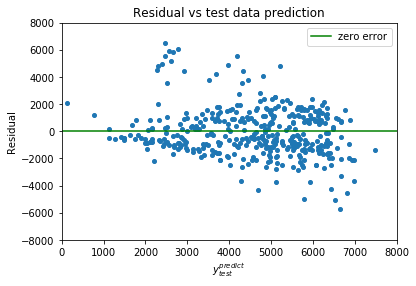

In [12]:
residual = y_test - y_test_predict
plt.plot(y_test_predict, residual, 'o', markersize=4)
plt.axhline(color='g', label='zero error')
plt.title('Residual vs test data prediction')
plt.xlabel('$y_{test}^{predict}$')
plt.ylabel('Residual')
plt.xlim((0, 8000))
plt.ylim((-8000, 8000))
plt.legend();

The residual plot reveals a non-linear relationship between the predictors and response as the points are not randomly scattered about zero error. We can see that the variance of the error terms grows for larger values of the predicted response.

## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

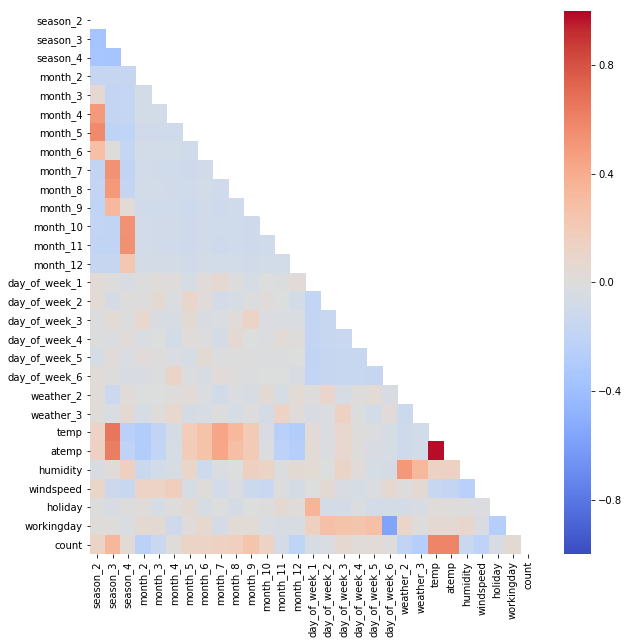

In [13]:
corr_matrix = bike_rentals_train_pp.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(corr_matrix)] = True
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, center=0,
            cmap='coolwarm', ax=ax);

We can clearly see that there are variables which fall into certain groups based on their correlation coefficients from the heat map. `temp` and `atemp` leap out at being very highly postively correlated with one another. It is also clear that we have high positive correlations between `temp` / `atemp` and `season_3` (season 3 = Fall) and certain months of the year and seasons (e.g. `season_4` and `month_11` - winter and November). Also, it's obvious that `day_of_week_6` (day 6 = Saturday) and `workingday` are also highly negatively correlated with one another. These are all signs that the data suffers from multi-collinearity and redundant variables can be removed.

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




In [14]:
def get_bic(X_train, y_train):
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    return model.bic

For forward selection:

In [15]:
predictors = [([], 0)]
for k in range(1, len(X_train.columns.drop('const'))):
    best_k_minus_1 = predictors[-1][0]
    bics = []

    new_predictors = list(set(X_train.columns.drop('const')) - set(best_k_minus_1))
    for predictor in new_predictors:
        k_predictors = best_k_minus_1 + [predictor] 
        X_train_for = bike_rentals_train_pp[k_predictors].values
        bics.append(get_bic(X_train_for, y_train))

    best_k = best_k_minus_1 + [new_predictors[np.argmin(bics)]]
    predictors.append((best_k, np.min(bics)))
predictors.remove(([], 0))

In [16]:
best_predictor_set_for = sorted(predictors, key=lambda t: t[1], reverse=True)[-1]
X_train_for = bike_rentals_train_pp[best_predictor_set_for[0]]
X_train_for = sm.add_constant(X_train_for)
X_test_for = bike_rentals_test_pp[best_predictor_set_for[0]]
X_test_for = sm.add_constant(X_test_for)
ols_for = OLS(y_train, X_train_for)
ols_for_results = ols_for.fit()
y_test_predict = ols_for_results.predict(X_test_for)

print('best predictor set: {}\nbic: {}\ntest R^2: {}'.format(
    best_predictor_set_for[0], best_predictor_set_for[1], r2_score(
        y_test, y_test_predict)))

best predictor set: ['atemp', 'humidity', 'season_4', 'month_9', 'season_2', 'weather_3', 'windspeed']
bic: 5743.099730261509
test R^2: 0.28522827352038493


For backward selection:

In [17]:
predictors = [(X_train.columns.drop('const'), get_bic(X_train, y_train))]
for k in range(len(X_train.columns.drop('const')), 1, -1):
    best_k_predictors = predictors[-1][0]
    bics = []

    for predictor in best_k_predictors:
        k_minus_1 = list(set(best_k_predictors) - set([predictor]))
        X_train_back = bike_rentals_train_pp[k_minus_1].values
        bics.append(get_bic(X_train_back, y_train))

    best_k_minus_1 = list(set(best_k_predictors) - set(
        [best_k_predictors[np.argmin(bics)]]))
    predictors.append((best_k_minus_1, np.min(bics)))

In [18]:
best_predictor_set_back = sorted(predictors, key=lambda t: t[1], reverse=True)[-1]
X_train_back = bike_rentals_train_pp[best_predictor_set_back[0]]
X_train_back = sm.add_constant(X_train_back)
X_test_back = bike_rentals_test_pp[best_predictor_set_back[0]]
X_test_back = sm.add_constant(X_test_back)
ols_back = OLS(y_train, X_train_back)
ols_back_results = ols_back.fit()
y_test_predict = ols_back_results.predict(X_test_back)

print('best predictor set: {}\nbic: {}\ntest R^2: {}'.format(
    best_predictor_set_back[0], best_predictor_set_back[1], r2_score(
        y_test, y_test_predict)))

best predictor set: ['humidity', 'windspeed', 'season_4', 'season_3', 'temp', 'weather_3', 'month_7', 'season_2', 'month_8', 'month_6']
bic: 5743.114545842088
test R^2: 0.27992774344938287


We can see that for both forward and backward stepwise selection that several of the redundant variables have been eliminated  and that the test $R^2$ score is higher than in part (b) using all predictors.

## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Evaluate each of the 3 models on the provided left out test set by calculating $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [19]:
def model_x_valid_r_squared(df_non_test, df_test, predictors, n_splits=3,
                            shuffle=False, random_state=None):
    X_non_test, y_non_test = make_features(df_non_test, predictors)
    
    validation_R_sqs = []
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    for train, val in kf.split(X_non_test):
        X_train, X_val = X_non_test.loc[train, :], X_non_test.loc[val, :]
        y_train, y_val = y_non_test[train], y_non_test[val]

        ols = OLS(y_train, X_train)
        ols_results = ols.fit()

        y_val_predict = ols_results.predict(X_val)
        validation_R_sqs.append(r2_score(y_true=y_val, y_pred=y_val_predict))

    return np.mean(validation_R_sqs)


def test_r_squared(df_non_test, df_test, predictors):
    X_non_test, y_non_test = make_features(df_non_test, predictors)
    X_test, y_test = make_features(df_test, predictors)

    ols = OLS(y_non_test, X_non_test)
    ols_results = ols.fit()

    y_test_predict = ols_results.predict(X_test)
    return r2_score(y_true=y_test, y_pred=y_test_predict)

In [20]:
model_predictors = {}
model_predictors['all'] = bike_rentals_train_pp.columns.drop('count').values
model_predictors['forward'] = best_predictor_set_for[0]
model_predictors['backward'] = best_predictor_set_back[0]

In [21]:
models_results = []
for model, predictors in model_predictors.items():
    val_r_sq = model_x_valid_r_squared(bike_rentals_train_pp,
                                       bike_rentals_test_pp, predictors,
                                       n_splits=10, shuffle=True, random_state=6)
    test_r_sq = test_r_squared(bike_rentals_train_pp, bike_rentals_test_pp,
                               predictors)
    model_results = {'model': model, 'predictors': np.array(predictors,
                                                            dtype=object),
                     'val_R_squared': val_r_sq, 'test_R_squared': test_r_sq}
    models_results.append(model_results)

models_results

[{'model': 'all',
  'predictors': array(['season_2', 'season_3', 'season_4', 'month_2', 'month_3',
         'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
         'month_10', 'month_11', 'month_12', 'day_of_week_1',
         'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
         'day_of_week_6', 'weather_2', 'weather_3', 'temp', 'atemp',
         'humidity', 'windspeed', 'holiday', 'workingday'], dtype=object),
  'val_R_squared': 0.40059408809295804,
  'test_R_squared': 0.25783629187453316},
 {'model': 'forward',
  'predictors': array(['atemp', 'humidity', 'season_4', 'month_9', 'season_2',
         'weather_3', 'windspeed'], dtype=object),
  'val_R_squared': 0.4857480094097834,
  'test_R_squared': 0.28522827352038493},
 {'model': 'backward',
  'predictors': array(['humidity', 'windspeed', 'season_4', 'season_3', 'temp',
         'weather_3', 'month_7', 'season_2', 'month_8', 'month_6'],
        dtype=object),
  'val_R_squared': 0.5023304330305

From the cross-validation we can see that the model to select according to $R^2$ is the step-wise backward model. However, according to the test set we can see that the model to select according to $R^2$ is the step-wise forward model. Both these models are better than the model with all predictors due to the removal of some predictors causing multi-collinearity. Beyond, this it is not obvious to me why the cross-validation and hold out set results do not agree even though it is clearly that they select a different subset of the predictors. One thing that I notice is that all the season predictors are selected in the backward model along with more of the moth variables. Maybe this leads to a better predictive model when evaluated on the hold out set. 